# Model Evaluation and Backtesting

This notebook demonstrates comprehensive model evaluation including backtesting, Sharpe ratio analysis, and performance visualization.

In [1]:
import sys
import os
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import mean_squared_error, r2_score, f1_score, classification_report, confusion_matrix

from src.utils.config import load_config

## Load Results and Data

In [2]:
cfg = load_config()

# Load predictions and backtest results
preds_path = os.path.join(cfg.processed_dir, 'predictions_classification.csv')
backtest_path = os.path.join(cfg.processed_dir, 'backtest.csv')
dataset_path = os.path.join(cfg.processed_dir, 'dataset.csv')
prices_path = os.path.join(cfg.raw_dir, 'prices.csv')

if not all(os.path.exists(p) for p in [preds_path, backtest_path, dataset_path, prices_path]):
    raise FileNotFoundError("Missing required files. Run predict.py and backtest.py first.")

preds = pd.read_csv(preds_path, parse_dates=['date'])
backtest = pd.read_csv(backtest_path, parse_dates=['date'])
dataset = pd.read_csv(dataset_path, parse_dates=['date'])
prices = pd.read_csv(prices_path, parse_dates=['Date']).set_index('Date')

print(f"Loaded predictions: {preds.shape}")
print(f"Loaded backtest: {backtest.shape}")
print(f"Loaded dataset: {dataset.shape}")
print(f"Loaded prices: {prices.shape}")

Loaded predictions: (1150, 7)
Loaded backtest: (1150, 3)
Loaded dataset: (5768, 35)
Loaded prices: (1442, 20)


## 1. Prediction Accuracy Analysis

Overall Classification Accuracy: 0.4383

Per-class Accuracy:
  high: 0.4116
  low: 0.6534
  medium: 0.2403


/var/folders/5d/_t857qg95d12wwnzqlwkz3cw0000gn/T/ipykernel_96129/1875690020.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  class_accuracy = preds.groupby('true_bucket').apply(


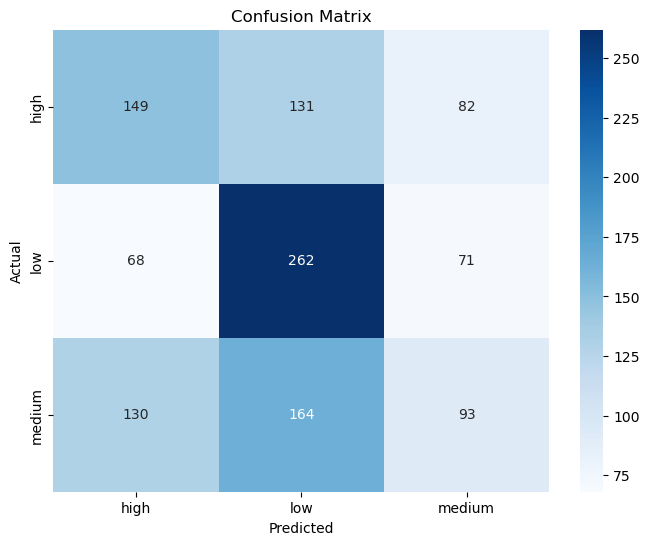

In [3]:
# Classification accuracy
accuracy = (preds['true_bucket'] == preds['pred_bucket']).mean()
print(f"Overall Classification Accuracy: {accuracy:.4f}")

# Per-class accuracy
class_accuracy = preds.groupby('true_bucket').apply(
    lambda x: (x['true_bucket'] == x['pred_bucket']).mean()
)
print("\nPer-class Accuracy:")
for bucket, acc in class_accuracy.items():
    print(f"  {bucket}: {acc:.4f}")

# Confusion matrix
cm = confusion_matrix(preds['true_bucket'], preds['pred_bucket'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['high', 'low', 'medium'], 
            yticklabels=['high', 'low', 'medium'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

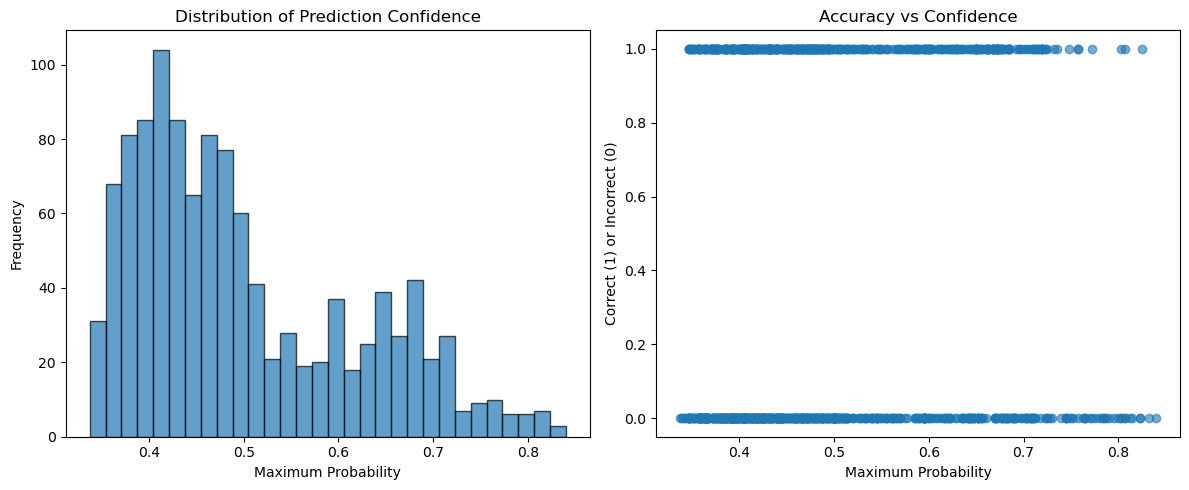

Average confidence: 0.4991
Confidence of correct predictions: 0.5068
Confidence of incorrect predictions: 0.4930


In [4]:
# Prediction confidence analysis
confidence_cols = [c for c in preds.columns if c.startswith('proba_')]
if confidence_cols:
    preds['max_confidence'] = preds[confidence_cols].max(axis=1)
    
    plt.figure(figsize=(12, 5))
    
    # Confidence distribution
    plt.subplot(1, 2, 1)
    plt.hist(preds['max_confidence'], bins=30, alpha=0.7, edgecolor='black')
    plt.title('Distribution of Prediction Confidence')
    plt.xlabel('Maximum Probability')
    plt.ylabel('Frequency')
    
    # Accuracy vs confidence
    plt.subplot(1, 2, 2)
    correct = (preds['true_bucket'] == preds['pred_bucket']).astype(int)
    plt.scatter(preds['max_confidence'], correct, alpha=0.6)
    plt.title('Accuracy vs Confidence')
    plt.xlabel('Maximum Probability')
    plt.ylabel('Correct (1) or Incorrect (0)')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Average confidence: {preds['max_confidence'].mean():.4f}")
    print(f"Confidence of correct predictions: {preds[correct==1]['max_confidence'].mean():.4f}")
    print(f"Confidence of incorrect predictions: {preds[correct==0]['max_confidence'].mean():.4f}")

## 2. Backtest Performance Analysis

In [5]:
# Calculate performance metrics
returns = backtest['strategy_return'].dropna()
cumulative_return = (1 + returns).cumprod()
total_return = cumulative_return.iloc[-1] - 1
volatility = returns.std() * np.sqrt(252)
sharpe_ratio = (returns.mean() * 252) / (returns.std() * np.sqrt(252))
max_drawdown = (cumulative_return / cumulative_return.cummax() - 1).min()

print("=== BACKTEST PERFORMANCE ===")
print(f"Total Return: {total_return:.2%}")
print(f"Annualized Volatility: {volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Number of Trading Days: {len(returns)}")

=== BACKTEST PERFORMANCE ===
Total Return: 61.58%
Annualized Volatility: 12.12%
Sharpe Ratio: 0.93
Maximum Drawdown: -18.76%
Number of Trading Days: 1150


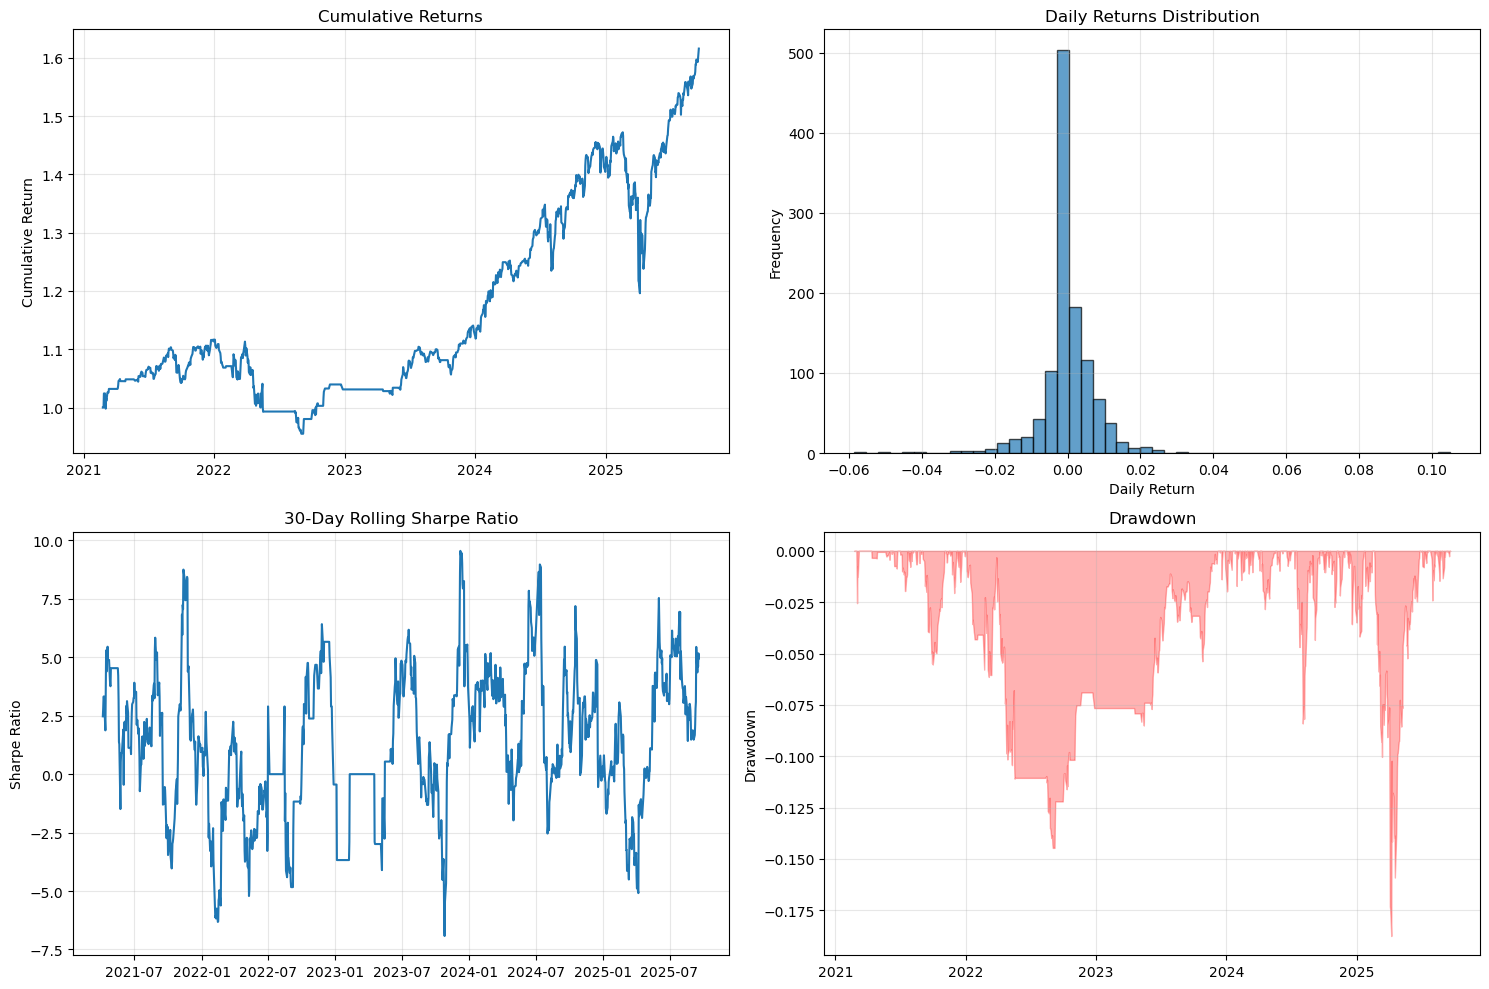

In [6]:
# Visualize backtest results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Cumulative returns
axes[0, 0].plot(backtest['date'], cumulative_return)
axes[0, 0].set_title('Cumulative Returns')
axes[0, 0].set_ylabel('Cumulative Return')
axes[0, 0].grid(True, alpha=0.3)

# Daily returns distribution
axes[0, 1].hist(returns, bins=50, alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Daily Returns Distribution')
axes[0, 1].set_xlabel('Daily Return')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# Rolling Sharpe ratio (30-day window)
rolling_sharpe = returns.rolling(30).apply(lambda x: (x.mean() * 252) / (x.std() * np.sqrt(252)) if x.std() > 0 else 0)
axes[1, 0].plot(backtest['date'], rolling_sharpe)
axes[1, 0].set_title('30-Day Rolling Sharpe Ratio')
axes[1, 0].set_ylabel('Sharpe Ratio')
axes[1, 0].grid(True, alpha=0.3)

# Drawdown
drawdown = cumulative_return / cumulative_return.cummax() - 1
axes[1, 1].fill_between(backtest['date'], drawdown, 0, alpha=0.3, color='red')
axes[1, 1].set_title('Drawdown')
axes[1, 1].set_ylabel('Drawdown')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Risk Bucket Analysis

Prediction Distribution by Risk Bucket:
             count
pred_bucket       
high           347
low            557
medium         246


/var/folders/5d/_t857qg95d12wwnzqlwkz3cw0000gn/T/ipykernel_96129/1356680524.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bucket_accuracy = preds.groupby('pred_bucket').apply(


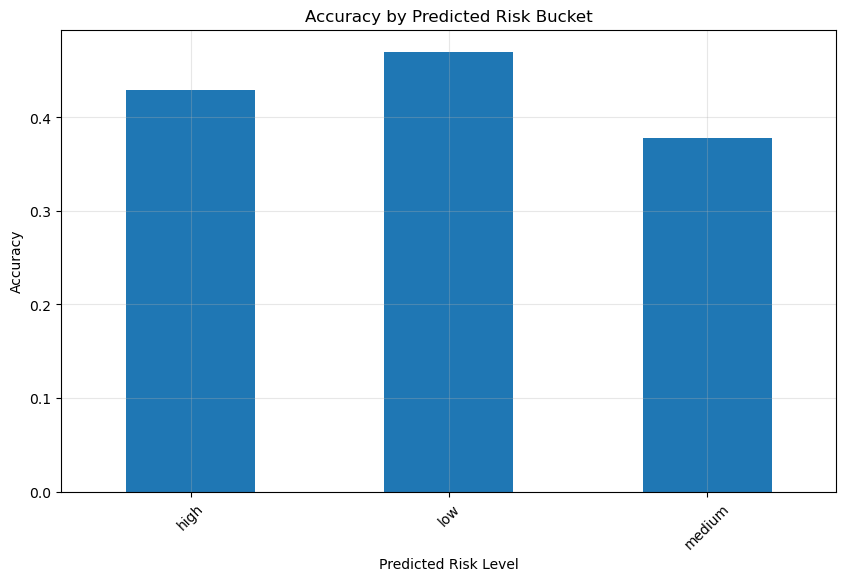


Accuracy by Predicted Bucket:
  high: 0.4294
  low: 0.4704
  medium: 0.3780


In [7]:
# Analyze performance by risk bucket
bucket_performance = preds.groupby('pred_bucket').agg({
    'true_bucket': 'count',  # Count of predictions
}).rename(columns={'true_bucket': 'count'})

print("Prediction Distribution by Risk Bucket:")
print(bucket_performance)

# Accuracy by predicted bucket
bucket_accuracy = preds.groupby('pred_bucket').apply(
    lambda x: (x['true_bucket'] == x['pred_bucket']).mean()
)

plt.figure(figsize=(10, 6))
bucket_accuracy.plot(kind='bar')
plt.title('Accuracy by Predicted Risk Bucket')
plt.xlabel('Predicted Risk Level')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.show()

print("\nAccuracy by Predicted Bucket:")
for bucket, acc in bucket_accuracy.items():
    print(f"  {bucket}: {acc:.4f}")

## 4. Feature Importance Analysis

In [8]:
# Load feature importance from saved models
import joblib

model_path = os.path.join(cfg.processed_dir, 'models', 'best_classification_model.pkl')
if os.path.exists(model_path):
    model = joblib.load(model_path)
    
    if hasattr(model, 'feature_importances_'):
        # Get feature names from dataset
        feature_cols = [c for c in dataset.columns if c not in {'date','ticker','rv_future','vol_bucket'} and dataset[c].dtype != 'O']
        
        feature_importance = pd.DataFrame({
            'feature': feature_cols,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        # Plot top 20 features
        plt.figure(figsize=(10, 8))
        top_features = feature_importance.head(20)
        plt.barh(range(len(top_features)), top_features['importance'])
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.title('Top 20 Feature Importance')
        plt.xlabel('Importance')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
        
        print("\nTop 10 Most Important Features:")
        for i, row in feature_importance.head(10).iterrows():
            print(f"  {row['feature']}: {row['importance']:.4f}")
else:
    print("Model file not found. Run training first.")

Model file not found. Run training first.


## 5. Interactive Dashboard Preview

In [9]:
# Create interactive plots for dashboard
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Cumulative Returns', 'Daily Returns', 'Prediction Accuracy', 'Feature Importance'),
    specs=[[{"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}]]
)

# Cumulative returns
fig.add_trace(
    go.Scatter(x=backtest['date'], y=cumulative_return, name='Cumulative Return'),
    row=1, col=1
)

# Daily returns
fig.add_trace(
    go.Scatter(x=backtest['date'], y=returns, name='Daily Return', mode='markers'),
    row=1, col=2
)

# Prediction accuracy over time
daily_accuracy = preds.groupby('date').apply(
    lambda x: (x['true_bucket'] == x['pred_bucket']).mean()
).reset_index()
daily_accuracy.columns = ['date', 'accuracy']

fig.add_trace(
    go.Scatter(x=daily_accuracy['date'], y=daily_accuracy['accuracy'], name='Daily Accuracy'),
    row=2, col=1
)

# Feature importance (top 10)
if 'feature_importance' in locals():
    top_10 = feature_importance.head(10)
    fig.add_trace(
        go.Bar(x=top_10['importance'], y=top_10['feature'], orientation='h', name='Feature Importance'),
        row=2, col=2
    )

fig.update_layout(height=800, showlegend=False, title_text="Model Performance Dashboard")
fig.show()

/var/folders/5d/_t857qg95d12wwnzqlwkz3cw0000gn/T/ipykernel_96129/2783995286.py:22: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



## 6. Summary and Recommendations

In [10]:
print("=== EVALUATION SUMMARY ===")
print(f"\nModel Performance:")
print(f"  Classification Accuracy: {accuracy:.2%}")
print(f"  Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"  Total Return: {total_return:.2%}")
print(f"  Maximum Drawdown: {max_drawdown:.2%}")

print(f"\nData Quality:")
print(f"  Total Predictions: {len(preds)}")
print(f"  Trading Days: {len(backtest)}")
print(f"  Date Range: {backtest['date'].min()} to {backtest['date'].max()}")

print(f"\nRecommendations:")
if sharpe_ratio > 1.0:
    print("  ✓ Good risk-adjusted returns")
else:
    print("  ⚠ Consider improving model or risk management")

if accuracy > 0.5:
    print("  ✓ Reasonable classification accuracy")
else:
    print("  ⚠ Consider feature engineering or model tuning")

if max_drawdown > -0.2:
    print("  ✓ Acceptable drawdown levels")
else:
    print("  ⚠ High drawdown - consider position sizing or stop-losses")

print(f"\nNext Steps:")
print("  1. Deploy model with real-time data")
print("  2. Monitor performance and retrain periodically")
print("  3. Consider ensemble methods for improved accuracy")
print("  4. Implement risk management rules")

=== EVALUATION SUMMARY ===

Model Performance:
  Classification Accuracy: 43.83%
  Sharpe Ratio: 0.93
  Total Return: 61.58%
  Maximum Drawdown: -18.76%

Data Quality:
  Total Predictions: 1150
  Trading Days: 1150
  Date Range: 2021-02-23 00:00:00 to 2025-09-19 00:00:00

Recommendations:
  ⚠ Consider improving model or risk management
  ⚠ Consider feature engineering or model tuning
  ✓ Acceptable drawdown levels

Next Steps:
  1. Deploy model with real-time data
  2. Monitor performance and retrain periodically
  3. Consider ensemble methods for improved accuracy
  4. Implement risk management rules
